<a href="https://colab.research.google.com/github/AndreaCamilloni/Online-learning-application-21-22/blob/main/OLA_lab02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hungarian algorithm

In [ ]:
import numpy as np
from scipy.optimize import linear_sum_assignment


In [ ]:
def step1(m):
  for i in range(m.shape[0]):
    m[i,:] = m[i,:] - np.min(m[i,:])

def step2(m):
  for i in range(m.shape[1]):
    m[:,i] = m[:,i] - np.min(m[:,i])

In [ ]:
def step3(m):
  dim = m.shape[0]
  assigned = np.array([])
  assignments = np.zeros(m.shape, dtype = int)

  for i in range(0, dim):
    for j in range(0, dim):
      if(m[i,j]==0 and np.sum(assignments[:,j])==0 and np.sum(assignments[i,:])==0):
        assignments[i,j] = 1
        assigned = np.append(assigned,i)
  rows = np.linspace(0, dim-1, dim).astype(int)
  marked_rows = np.setdiff1d(rows,assigned)
  new_marked_rows = marked_rows.copy()
  marked_cols = np.array([])

  while(len(new_marked_rows)>0):
    new_marked_cols = np.array([], dtype = int)
    for nr in new_marked_rows:
      zeros_cols = np.argwhere(m[nr,:]==0).reshape(-1)
      new_marked_cols = np.append(new_marked_cols, np.setdiff1d(zeros_cols, marked_cols))
    marked_cols = np.append(marked_cols, new_marked_cols)
    new_marked_rows = np.array([], dtype = int)
  
    for nc in new_marked_cols:
      new_marked_rows = np.append(new_marked_rows, np.argwhere(assignments[:,nc]==1).reshape(-1))
    marked_rows = np.unique(np.append(marked_rows, new_marked_rows))
  return np.setdiff1d(rows, marked_rows).astype(int), np.unique(marked_cols)

In [ ]:
def step5(m, covered_rows, covered_cols):
  uncovered_rows= np.setdiff1d(np.linspace(0, m.shape[0]-1, m.shape[0]), covered_rows).astype(int)
  uncovered_cols= np.setdiff1d(np.linspace(0, m.shape[1]-1, m.shape[1]), covered_cols).astype(int)
  min_val = np.max(m)
  for i in uncovered_rows.astype(int):
    for j in uncovered_cols.astype(int):
      if(m[i,j]<min_val):
        min_val = m[i,j]
  
  for i in uncovered_rows.astype(int):
    m[i,:] -= min_val
  
  for j in covered_cols.astype(int):
    m[:,j] += min_val
  
  return m

In [ ]:
def find_rows_single_zero(matrix):
   for i in range(0, matrix.shape[0]):
     if(np.sum(matrix[i,:] == 0) == 1):
       j = np.argwhere(matrix[i,:] == 0).reshape(-1)[0]
       return i, j
     return False

def find_cols_single_zero(matrix):
   for i in range(0, matrix.shape[1]):
     if(np.sum(matrix[:,i] == 0) == 1):
       j = np.argwhere(matrix[:,i] == 0).reshape(-1)[0]
       return i, j
     return False


def assignment_single_zero_lines(m, assignment):
  val = find_rows_single_zero(m)
  while(val):
    i,j = val[0], val[1]
    m[i,j] +=1
    m[:,j] +=1
    assignment[i,j] = 1
    val = find_rows_single_zero(m)
  
  val = find_cols_single_zero(m)
  while(val):
    i,j = val[0], val[1]
    m[i,:] +=1
    m[i,j] +=1
    assignment[i,j] = 1
    val = find_cols_single_zero(m)
  return assignment

def first_zero(m):
  return np.argwhere(m==0)[0][0], np.argwhere(m==0)[0][1]
def final_assignment(initial_matrix, m ):
  assignment = np.zeros(m.shape, dtype = int)
  assignment = assignment_single_zero_lines(m, assignment)
  while(np.sum(m==0)>0):
    i,j = first_zero(m)
    assignment[i,j] = 1
    m[i,:] += 1
    m[:,j] += 1
    assignment = assignment_single_zero_lines(m, assignment)
  
  return assignment * initial_matrix, assignment

def hungarian_alg(matrix):
  m = matrix.copy()
  step1(m)
  step2(m)
  n_lines = 0
  max_lenght = np.maximum(m.shape[0], m.shape[1])
  while n_lines!= max_lenght:
    lines = step3(m)
    n_lines = len(lines[0]) + len(lines[1])
    if(n_lines != max_lenght):
      step5(m, lines[0], lines[1])
  return final_assignment(matrix, m)



In [ ]:
a = np.random.randint(100, size = (3,3))
res = hungarian_alg(a)
print("\n optimal matchin: \n", res[1], "\n value: ", np.sum(res[0]))


 optimal matchin: 
 [[1 0 0]
 [0 0 1]
 [0 0 0]] 
 value:  59


# CUSUM-UCB for Online Matching in Non-Stationary Environments

In [ ]:
import numpy as np

class learner:
  def __init__(self,n_arms):
    self.t = 0
    self.n_arms = n_arms
    self.rewards = []
    self.reward_per_arm = [[] for _ in range(n_arms)]

  def reset(self):
    self.__init__(self.n_arms, self.prices)
  def act(self):
    pass
  
  def update(self, arm_pulled, reward):
    self.t += 1
    self.rewards.append(reward)
    self.reward_per_arm[arm_pulled].append(reward)


In [ ]:
class UCB(learner):
  def __init__(self,n_arms):
    super().__init__(n_arms)
    self.empirical_means = np.zeros(n_arms)
    self.confidence = np.array([np.inf]*n_arms)

  def pull_arm(self):
    upper_conf = self.empirical_means + self.confidence
    return np.random.choice(np.where(upper_conf == upper_conf.max())[0])

  def update(self, pull_arm, reward):
    self.t += 1
    self.empirical_means[pull_arm] = (self.empirical_means[pull_arm]*(self.t-1) + reward)/self.t
    for a in range(self.n_arms):
      n_samples = len(self.rewards_per_arm[a])
      self.confidence[a] = (2*np.log(self.t)/n_samples)**0.5 if n_samples > 0 else np.inf
    self.update_observations(pull_arm, reward)
  
   

In [ ]:
class Environment():
    def __init__(self,n_arms,probabilities):
        self.n_arms = n_arms
        self.probabilities = probabilities

    def round(self,pulled_arm):
        reward = np.random.binomial(1, self.probabilities[pulled_arm])
        return reward

In [ ]:
from scipy.optimize import linear_sum_assignment

probs = np.array([[1/4, 1, 1/4], [1/2, 1/4, 1/4], [1/4, 1/4, 1]])
costs = -probs

print(linear_sum_assignment(costs))

(array([0, 1, 2]), array([1, 0, 2]))


In [ ]:
class UCB_Matching(UCB):
  def __init__(self, n_arms, n_rows, n_cols):
    super().__init__(n_arms)
    self.n_rows = n_rows
    self.n_cols = n_cols
    assert n_arms == n_cols * n_rows
  
  def pull_arm(self):
    upper_conf = self.empirical_means + self.confidence
    upper_conf[np.isinf(upper_conf)] = 1e3
    row_ind, col_ind = linear_sum_assignment(-upper_conf.reshape(self.n_rows, self.n_cols))
    return (row_ind, col_ind)
  
  def update(self, pulled_arms, rewards):
    self.t += 1
    pulled_arm_flat = np.ravel_multi_index(pulled_arms, (self.n_rows, self.n_cols))
    for a in range(self.n_arms):
      n_samples = len(self.reward_per_arm[a])
      self.confidence[a] = (2*np.log(self.t)/n_samples)**0.5 if n_samples > 0 else np.inf
    


0
1
2
3
4
5
6
7
8
9


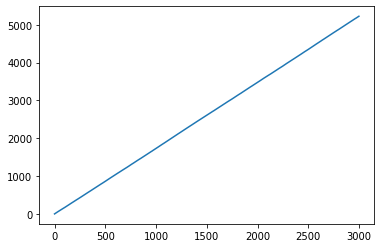

In [ ]:
if __name__ == '__main__':
  import matplotlib.pyplot as plt

  p = np.array([[1/4, 1, 1/4], [1/2, 1/4, 1/4], [1/4, 1/4, 1]])
  opt = linear_sum_assignment(-p)
  n_exp=10
  T = 3000
  regret_ucb = np.zeros((n_exp, T))
  for e in range(n_exp):
    learner = UCB_Matching(p.size, *p.shape)
    print(e)
    rew_UCB = []
    opt_rew = []
    env = Environment(p.size, p)
    for t in range(T):
      pulled_arms = learner.pull_arm()
      rewards = env.round(pulled_arms)
      learner.update(pulled_arms, rewards)
      rew_UCB.append(rewards.sum())
      opt_rew.append(p[opt].sum())
    regret_ucb[e,:] = np.cumsum(opt_rew)-np.cumsum(rew_UCB)

  plt.plot(regret_ucb.mean(axis=0))
  plt.show()

